In [2]:
import pandas as pd
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#stream directy from github
import requests
import csv

#Get Continent name
import pycountry_convert as pc
import pycountry

from datetime import datetime

#Get coordinates
from geopy.geocoders import Nominatim

#For mapping
from shapely.geometry import Polygon

#Disable Warning in cell 6
pd.options.mode.chained_assignment = None

In [3]:
URL = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'

with requests.Session() as s:
    download = s.get(URL)
    decoded_content = download.content.decode('utf-8')
    
    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(cr)

In [4]:
df_new = pd.DataFrame(my_list, columns=my_list[0]).drop([0])
df_new.iloc[50:100,:]

iso_code     location        date total_cases new_cases total_deaths  \
51       ABW        Aruba  2020-05-12         101         0            3   
52       ABW        Aruba  2020-05-13         101         0            3   
53       ABW        Aruba  2020-05-14         101         0            3   
54       ABW        Aruba  2020-05-15         101         0            3   
55       ABW        Aruba  2020-05-16         101         0            3   
56       ABW        Aruba  2020-05-17         101         0            3   
57       ABW        Aruba  2020-05-18         101         0            3   
58       ABW        Aruba  2020-05-19         101         0            3   
59       ABW        Aruba  2020-05-20         101         0            3   
60       ABW        Aruba  2020-05-21         101         0            3   
61       ABW        Aruba  2020-05-22         101         0            3   
62       AFG  Afghanistan  2019-12-31           0         0            0   
63       AFG  Afghanistan  2020-01-01           0         0            0   
64       AFG  Afghanistan  2020-01-02           0         0            0   
65       AFG  Afghanistan  2020-01-03           0         0            0   
66       AFG  Afghanistan  2020-01-04           0         0            0   
67       AFG  Afghanistan  2020-01-05           0         0            0   
68       AFG  Afghanistan  2020-01-06           0         0            0   
69       AFG  Afghanistan  2020-01-07           0         0            0   
70       AFG  Afghanistan  2020-01-08           0         0            0   
71       AFG  Afghanistan  2020-01-09           0         0            0   
72       AFG  Afghanistan  2020-01-10           0         0            0   
73       AFG  Afghanistan  2020-01-11           0         0            0   
74       AFG  Afghanistan  2020-01-12           0         0            0   
75       AFG  Afghanistan  2020-01-13           0         0            0   
76       AFG  Afghanistan  2020-01-14           0         0            0   
77       AFG  Afghanistan  2020-01-15           0         0            0   
78       AFG  Afghanistan  2020-01-16           0         0            0   
79       AFG  Afghanistan  2020-01-17           0         0            0   
80       AFG  Afghanistan  2020-01-18           0         0            0   
81       AFG  Afghanistan  2020-01-19           0         0            0   
82       AFG  Afghanistan  2020-01-20           0         0            0   
83       AFG  Afghanistan  2020-01-21           0         0            0   
84       AFG  Afghanistan  2020-01-22           0         0            0   
85       AFG  Afghanistan  2020-01-23           0         0            0   
86       AFG  Afghanistan  2020-01-24           0         0            0   
87       AFG  Afghanistan  2020-01-25           0         0            0   
88       AFG  Afghanistan  2020-01-26           0         0            0   
89       AFG  Afghanistan  2020-01-27           0         0            0   
90       AFG  Afghanistan  2020-01-28           0         0            0   
91       AFG  Afghanistan  2020-01-29           0         0            0   
92       AFG  Afghanistan  2020-01-30           0         0            0   
93       AFG  Afghanistan  2020-01-31           0         0            0   
94       AFG  Afghanistan  2020-02-01           0         0            0   
95       AFG  Afghanistan  2020-02-02           0         0            0   
96       AFG  Afghanistan  2020-02-03           0         0            0   
97       AFG  Afghanistan  2020-02-04           0         0            0   
98       AFG  Afghanistan  2020-02-05           0         0            0   
99       AFG  Afghanistan  2020-02-06           0         0            0   
100      AFG  Afghanistan  2020-02-07           0         0            0   

    new_deaths total_cases_per_million new_cases_per_million  \
51           0                 945.994                   0.0   

In [5]:
#Add continent column - this results in errors because country name differentiate
to_country_code = lambda row: pc.country_name_to_country_alpha2(row, cn_name_format="default")
try:
    country_code = new_df['location'].apply(to_country_code)
except:
    NameError

In [6]:
#Rename some countries to work

#Côte d'Ivoire
location_ivory_coast = df_new.location[df_new.location == "Cote d'Ivoire"]
df_new.location[df_new.location == "Cote d'Ivoire"] = location_ivory_coast.replace(to_replace = "Cote d'Ivoire",value="Côte d'Ivoire")

#Faroe Islands
location_faroe_islands = df_new.location[df_new.location == "Faeroe Islands"]
df_new.location[df_new.location == "Faeroe Islands"] = location_faroe_islands.replace(to_replace = "Faeroe Islands",value="Faroe Islands")

#Democratic Republic of the Congo
location_drc = df_new.location[df_new.location == "Democratic Republic of Congo"]
df_new.location[df_new.location == "Democratic Republic of Congo"] = location_drc.replace(to_replace = "Democratic Republic of Congo",value="Democratic Republic of the Congo")

#Curaçao
location_curacao = df_new.location[df_new.location == "Curacao"]
df_new.location[df_new.location == "Curacao"] = location_curacao.replace(to_replace = "Curacao",value="Curaçao")


#Reset Timor to Timor-Leste (proper name)
location_timor = df_new.location[df_new.location == "Timor"]
df_new.location[df_new.location == "Timor"] = location_timor.replace(to_replace = "Timor",value="Timor-Leste")

In [7]:
def create_continent():
    
    '''
    Input: None
    Output: Complete series with continent names
    '''
    #Initializes new Series
    conti_column = pd.Series([],dtype='object')

    continents = {
        'NA': 'North America',
        'SA': 'South America', 
        'AS': 'Asia',
        'OC': 'Australia',
        'AF': 'Africa',
        'EU': 'Europe'}
    
    #Checks which countries have problems using when converting from the 2 country
    #code to continent name, adds these countries to a set
    stuck_alpha2 = set()
    for row in df_new['location']:
        try:
            continents[pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(row))]
        except:
            stuck_alpha2.add(row)

            
            
    
    #Fills in continent name for countries without converting problems and leaves the
    #others as np.nan
    for index,country in enumerate(df_new.location):
        if country in set(df_new.location[~df_new['location'].isin(list(stuck_alpha2))]):
            conti_column.loc[index] = continents[pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))]
        else:
            conti_column.loc[index] = np.nan
            
    return conti_column

    #Manually add Continent names for the stuck_alpha2 countries


df_new['continent'] = create_continent()

In [8]:
#Here display the countries that return errors
continents = {
        'NA': 'North America',
        'SA': 'South America', 
        'AS': 'Asia',
        'OC': 'Australia',
        'AF': 'Africa',
        'EU': 'Europe'}

stuck_alpha2 = set()
for row in df_new['location']:
    try:
        continents[pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(row))]
    except:
        stuck_alpha2.add(row)
stuck_alpha2

{'Bonaire Sint Eustatius and Saba',
 'International',
 'Kosovo',
 'Sint Maarten (Dutch part)',
 'Timor-Leste',
 'Vatican',
 'Western Sahara',
 'World'}

In [9]:
#lets change continent values of the stuck alpha2 rows
df_new['continent'][df_new.location == "Bonaire Sint Eustatius and Saba"] = "North America"
df_new['continent'][df_new.location == "Vatican"] = "Europe"
df_new['continent'][df_new.location == "Sint Maarten (Dutch part)"] = "North America"
df_new['continent'][df_new.location == "Timor-Leste"] = "Asia"
df_new['continent'][df_new.location == "Kosovo"] = "Europe"
df_new['continent'][df_new.location == "Western Sahara"] = "Africa"

In [10]:
def create_alpha2():
    alpha2_column = pd.Series(dtype='object')
    
    for index, alpha3 in enumerate(df_new.iso_code):
        try:
            alpha2_column.loc[index] = pc.country_alpha3_to_country_alpha2(alpha3)
        #The only country that appeared to have a error converting is Kosovo
        except:
            if alpha3 == 'RKS':
                alpha2_column.loc[index] = 'XK'
    
    return alpha2_column

df_new['alpha2'] = create_alpha2()

In [11]:
#Here the countries that have nan entries for continent name
continent_nan = df_new[(df_new['continent'].isna())
                & (df_new['location'] != 'World')
                & (df_new['location'] != 'International')]

'''for row in continent_nan.index:
    try:
        change_alpha = pc.country_name_to_country_alpha2(df_new.iloc[row].location)
        #change alpha2
        df_new.iloc[row].alpha2 = change_alpha
        #set continent name
        df_new.iloc[index].continent = pc.country_alpha2_to_continent_code(df_new.iloc[index].alpha2)
    except:
        print (df_new.iloc[row].location)'''

'for row in continent_nan.index:\n    try:\n        change_alpha = pc.country_name_to_country_alpha2(df_new.iloc[row].location)\n        #change alpha2\n        df_new.iloc[row].alpha2 = change_alpha\n        #set continent name\n        df_new.iloc[index].continent = pc.country_alpha2_to_continent_code(df_new.iloc[index].alpha2)\n    except:\n        print (df_new.iloc[row].location)'

In [12]:
#Check for nan Values
continent_nan.isna().sum().continent

7

In [13]:
#Get coordinates
def create_coordinates(column):
    
    geolocator = Nominatim(user_agent="Get_Coordinates")
    #Dict with country key and coordinates value
    #country_coordinates_dict = dict()
    country_latitude_dict = dict()
    country_longitude_dict = dict()
    
    for i in column.unique():
        try:
            loc = geolocator.geocode(i)
            #country_coordinates_dict[i] = [loc.latitude, loc.longitude]
            country_latitude_dict[i] = loc.latitude
            country_longitude_dict[i] = loc.longitude
        except:
            #"Swaziland" to "eSwatini"
            #"Sint Maarten (Dutch part)" to "Sint Maarten"
            if  i == "Sint Maarten (Dutch part)":
                loc_error1 = geolocator.geocode('Sint Maarten')
                #country_coordinates_dict[i] = (loc_error1.latitude, loc_error1.longitude)
                country_latitude_dict[i] = loc_error1.latitude
                country_longitude_dict[i] = loc_error1.longitude
            elif i == "Swaziland":
                loc_error2 = geolocator.geocode('eSwatini')
                #country_coordinates_dict[i] = (loc_error2.latitude, loc_error2.longitude)
                country_latitude_dict[i] = loc_error2.latitude
                country_longitude_dict[i] = loc_error2.longitude
    return country_latitude_dict, country_longitude_dict

In [14]:
#create new lat,long columns
df_new['latitude'] = df_new['location'].map(create_coordinates(df_new.location)[0])
df_new['longitude'] = df_new['location'].map(create_coordinates(df_new.location)[1])

In [15]:
#Use the preloaded world dataframe to get geodata for maps
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.head()

pop_est      continent                      name iso_a3  gdp_md_est  \
0     920938        Oceania                      Fiji    FJI      8374.0   
1   53950935         Africa                  Tanzania    TZA    150600.0   
2     603253         Africa                 W. Sahara    ESH       906.5   
3   35623680  North America                    Canada    CAN   1674000.0   
4  326625791  North America  United States of America    USA  18560000.0   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

In [16]:
#edit wrong columns
#france has -99 as its iso_a3 code
world.iso_a3[world.name == 'France'] = 'FRA'
world.iso_a3[world.name == 'Norway'] = 'NOR'

#set index of world and df_new dataframes
set_index_df = df_new.set_index('iso_code')
set_index_world = world.set_index('iso_a3')

#set new dataframe that joins both df's
df = set_index_world.join(set_index_df, lsuffix = '_other').reset_index()
df = df.drop(['index', 'pop_est', 'continent_other', 'name', 'gdp_md_est'],axis=1)

In [17]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 15922 entries, 0 to 15921
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   geometry                         15922 non-null  geometry
 1   location                         15913 non-null  object  
 2   date                             15913 non-null  object  
 3   total_cases                      15913 non-null  object  
 4   new_cases                        15913 non-null  object  
 5   total_deaths                     15913 non-null  object  
 6   new_deaths                       15913 non-null  object  
 7   total_cases_per_million          15913 non-null  object  
 8   new_cases_per_million            15913 non-null  object  
 9   total_deaths_per_million         15913 non-null  object  
 10  new_deaths_per_million           15913 non-null  object  
 11  total_tests                      15913 non-null  object  
 

In [18]:
#make date variable of datetime attribute
df['date'] = pd.to_datetime(df.date,format = '%Y/%m/%d')

In [19]:
#convert columns to float
cols_to_int = ['total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cvd_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'handwashing_facilities', 'hospital_beds_per_100k']
for i in cols_to_int:
    df[i] = pd.to_numeric(df[i],downcast='float')

In [20]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 15922 entries, 0 to 15921
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   geometry                         15922 non-null  geometry      
 1   location                         15913 non-null  object        
 2   date                             15913 non-null  datetime64[ns]
 3   total_cases                      15913 non-null  float32       
 4   new_cases                        15913 non-null  float32       
 5   total_deaths                     15913 non-null  float32       
 6   new_deaths                       15913 non-null  float32       
 7   total_cases_per_million          15710 non-null  float32       
 8   new_cases_per_million            15710 non-null  float32       
 9   total_deaths_per_million         15710 non-null  float32       
 10  new_deaths_per_million           15710 non-null  f

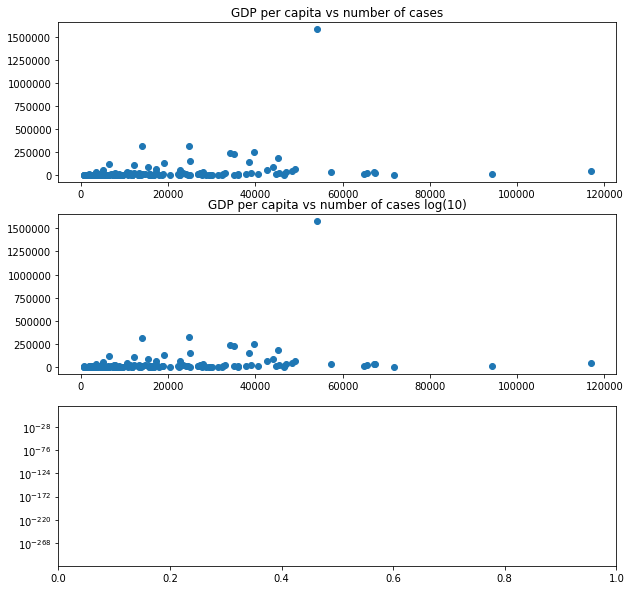

In [21]:
total_cases_country = df.groupby('location').total_cases.max()
country_gdp = df.groupby('location').gdp_per_capita.mean()

fig, arr_ax = plt.subplots(3, figsize=(10,10))

arr_ax[0].scatter(country_gdp,total_cases_country)
arr_ax[0].set_title("GDP per capita vs number of cases")
arr_ax[1].scatter(x=country_gdp,y=total_cases_country)
arr_ax[1].set_title("GDP per capita vs number of cases log(10)")
plt.yscale("log")

plt.show();

In [22]:
#create pandas series that matches country to continent  
continent_dict = dict()
for country in df.groupby('location'):
    continent_dict[country[0]] = country[1].continent.unique()[0]
country2continent = pd.Series(continent_dict)

#create pandas series that matches country to its population  
population_dict = dict()
for country in df.groupby('location'):
    population_dict[country[0]] = country[1].population.unique()[0]
country2population = pd.Series(population_dict)

#create pandas series that matches country to its population  
geo_dict = dict()
for country in df.groupby('location'):
    geo_dict[country[0]] = country[1].geometry.unique()[0]
country2geometry = geopandas.GeoSeries(geo_dict)

In [23]:
#create df to put all above data together
continent_df = pd.concat([total_cases_country,country_gdp],axis=1)
continent_df['continent'] = country2continent
continent_df['population'] = country2population
continent_df.head()

total_cases  gdp_per_capita      continent  population
location                                                           
Afghanistan       8676.0     1803.987061           Asia  38928340.0
Albania            969.0    11803.430664         Europe   2877800.0
Algeria           7728.0    13913.838867         Africa  43851044.0
Angola              58.0     5819.495117         Africa  32866268.0
Argentina         9918.0    18933.906250  South America  45195776.0

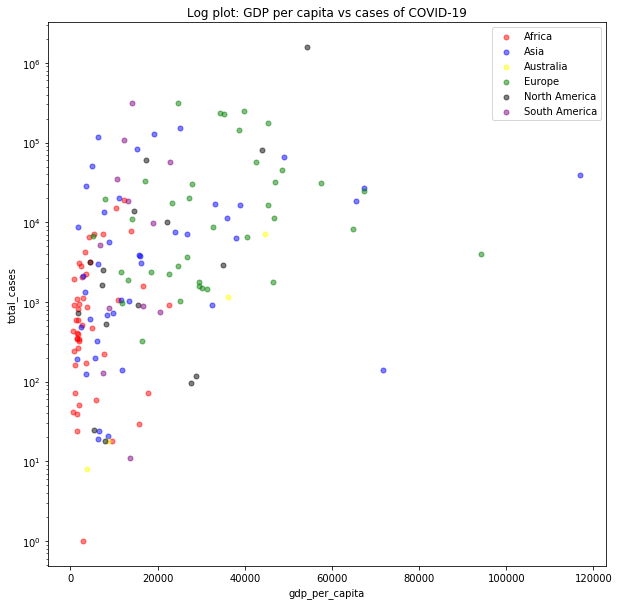

In [24]:
fig, ax = plt.subplots(figsize = (10,10))

#color of dots
color = {'Africa':'red',
         'Asia':'blue',
         'Europe':'green',
         'North America':'black',
         'Australia':'yellow',
         'South America':'purple'}

# plot scatter plot
grouped = continent_df.reset_index().groupby('continent')
for key, group in grouped:
    group.plot(ax=ax,
                kind='scatter',
                x='gdp_per_capita',
                y='total_cases',
                label=key,
                color=color[key],
                alpha = 0.5,
                s =25)
plt.yscale("log")

plt.title("Log plot: GDP per capita vs cases of COVID-19")
plt.legend()
plt.show()

In [25]:
#Above graph with population as dot size

In [26]:
#create geodataframe to make chloropleth map
total_cases_df = geopandas.GeoDataFrame(pd.concat([continent_df, country2geometry.rename('geometry')], axis=1))

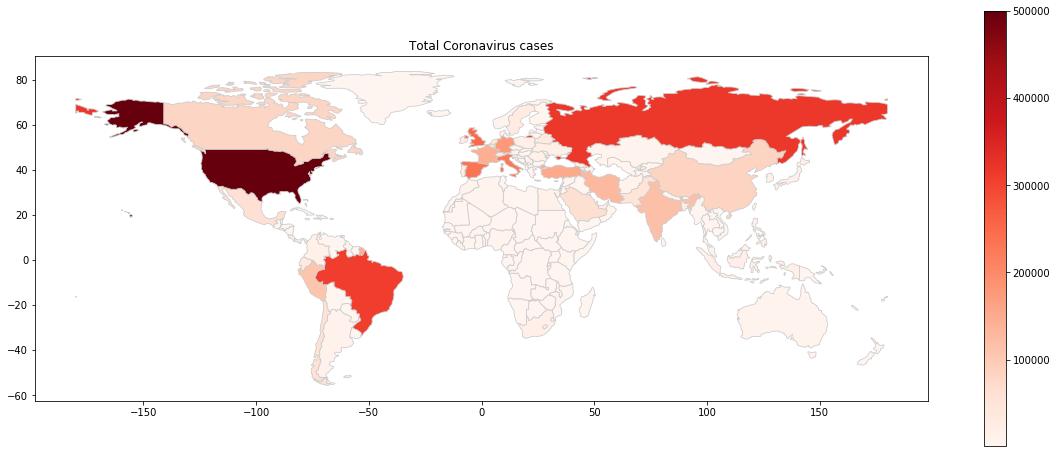

In [27]:
# set the range for the choropleth
vmin, vmax = 1000, 500000
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 8))

total_cases_df.plot(column='total_cases',
                    cmap='Reds',
                    linewidth=0.8,
                    ax=ax,
                    edgecolor='0.8',
                    vmin=vmin,
                    vmax=vmax)
ax.set_title("Total Coronavirus cases")

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

plt.show();

In [28]:
df

geometry     location  \
0      POLYGON ((32.73178 35.14003, 32.80247 35.14550...          NaN   
1      POLYGON ((48.94820 11.41062, 48.94820 11.41062...          NaN   
2      POLYGON ((20.59025 41.85541, 20.52295 42.21787...          NaN   
3      POLYGON ((66.51861 37.36278, 67.07578 37.35614...  Afghanistan   
4      POLYGON ((66.51861 37.36278, 67.07578 37.35614...  Afghanistan   
...                                                  ...          ...   
15917  POLYGON ((31.19141 -22.25151, 30.65987 -22.151...     Zimbabwe   
15918  POLYGON ((31.19141 -22.25151, 30.65987 -22.151...     Zimbabwe   
15919  POLYGON ((31.19141 -22.25151, 30.65987 -22.151...     Zimbabwe   
15920  POLYGON ((31.19141 -22.25151, 30.65987 -22.151...     Zimbabwe   
15921  POLYGON ((31.19141 -22.25151, 30.65987 -22.151...     Zimbabwe   

            date  total_cases  new_cases  total_deaths  new_deaths  \
0            NaT          NaN        NaN           NaN         NaN   
1            NaT          NaN        NaN           NaN         NaN   
2            NaT          NaN        NaN           NaN         NaN   
3     2019-12-31          0.0        0.0           0.0         0.0   
4     2020-01-01          0.0        0.0           0.0         0.0   
...          ...          ...        ...           ...         ...   
15917 2020-05-18         46.0        2.0           4.0         0.0   
15918 2020-05-19         46.0        0.0           4.0         0.0   
15919 2020-05-20         46.0        0.0           4.0         0.0   
15920 2020-05-21         48.0        2.0           4.0         0.0   
15921 2020-05-22         51.0        3.0           4.0         0.0   

       total_cases_per_million  new_cases_per_million  \
0                          NaN                    NaN   
1                          NaN                    NaN   
2                          NaN                    NaN   
3                        0.000                  0.000   
4                        0.000                  0.000   
...                        ...                    ...   
15917                    3.095                  0.135   
15918                    3.095                  0.000   
15919                    3.095                  0.000   
15920                    3.230                  0.135   
15921                    3.431                  0.202   

       total_deaths_per_million  ...  cvd_death_rate  diabetes_prevalence  \
0                           NaN  ...             NaN                  NaN   
1                           NaN  ...             NaN                  NaN   
2                           NaN  ...             NaN                  NaN   
3                         0.000  ...      597.028992                 9.59   
4                         0.000  ...      597.028992                 9.59   
...                         ...  ...             ...                  ...   
15917                     0.269  ...      307.846008                 1.82   
15918                     0.269  ...      307.846008                 1.82   
15919                     0.269  ...      307.846008                 1.82   
15920                     0.269  ...      307.846008                 1.82   
15921                     0.269  ...      307.846008                 1.82   

       female_smokers  male_smokers  handwashing_facilities  \
0                 NaN           NaN                     NaN   
1                 NaN           NaN                     NaN   
2                 NaN           NaN                     NaN   
3                 NaN           NaN               37.745998   
4                 NaN           NaN               37.745998   
...               ...           ...                     ...   
15917             1.6     30.700001               36.791000   
15918             1.6     30.700001               36.791000   
15919             1.6     30.700001               36.791000   
15920             1.6     30.700001               36.791000   
15921             1.6     3

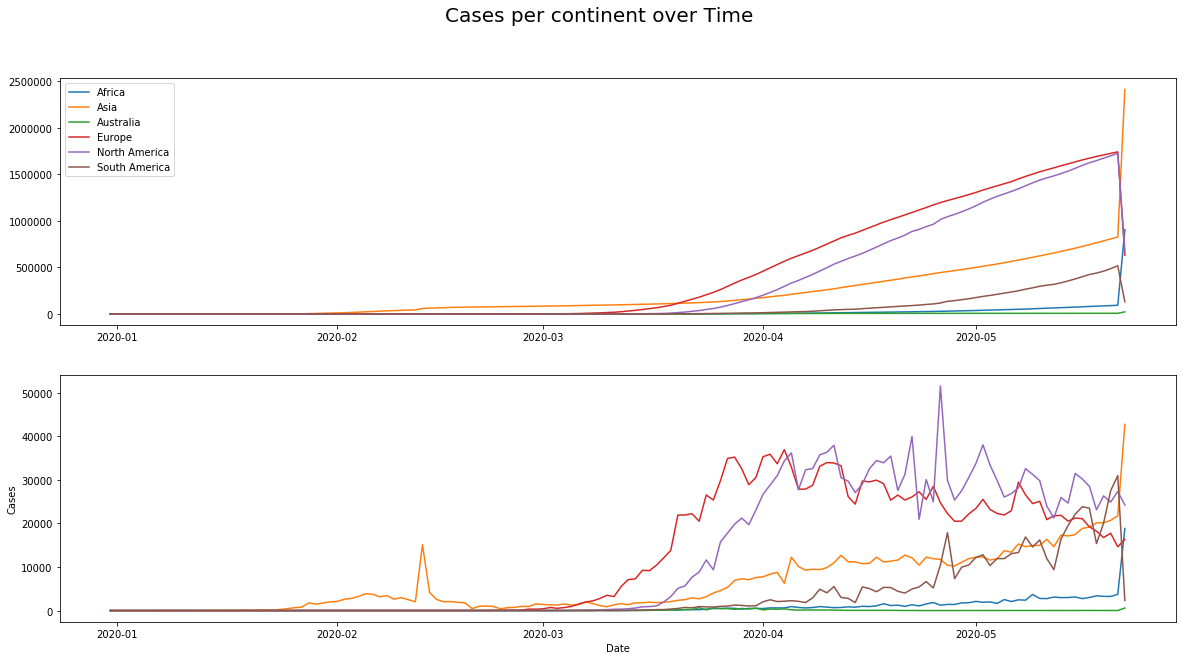

In [29]:
cont_date = df.groupby(['continent','date']).sum().reset_index()
today_date = cont_date[cont_date.date == pd.to_datetime(datetime.strftime(datetime.now(),format = '%Y-%m-%d'))].index

#updated dataframe without todays date included
cont_date = cont_date.drop(today_date)

fig, ax = plt.subplots(2, figsize=(20, 10))

for continent in cont_date.continent.unique():
    ax[0].plot(cont_date[cont_date.continent ==continent]['date'],
            cont_date[cont_date.continent ==continent]['total_cases'],label = continent)
    ax[1].plot(cont_date[cont_date.continent ==continent]['date'],
            cont_date[cont_date.continent ==continent]['new_cases'],label = continent)

fig.suptitle('Cases per continent over Time',fontsize=20)
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Cases")
    
ax[0].legend()
plt.show()

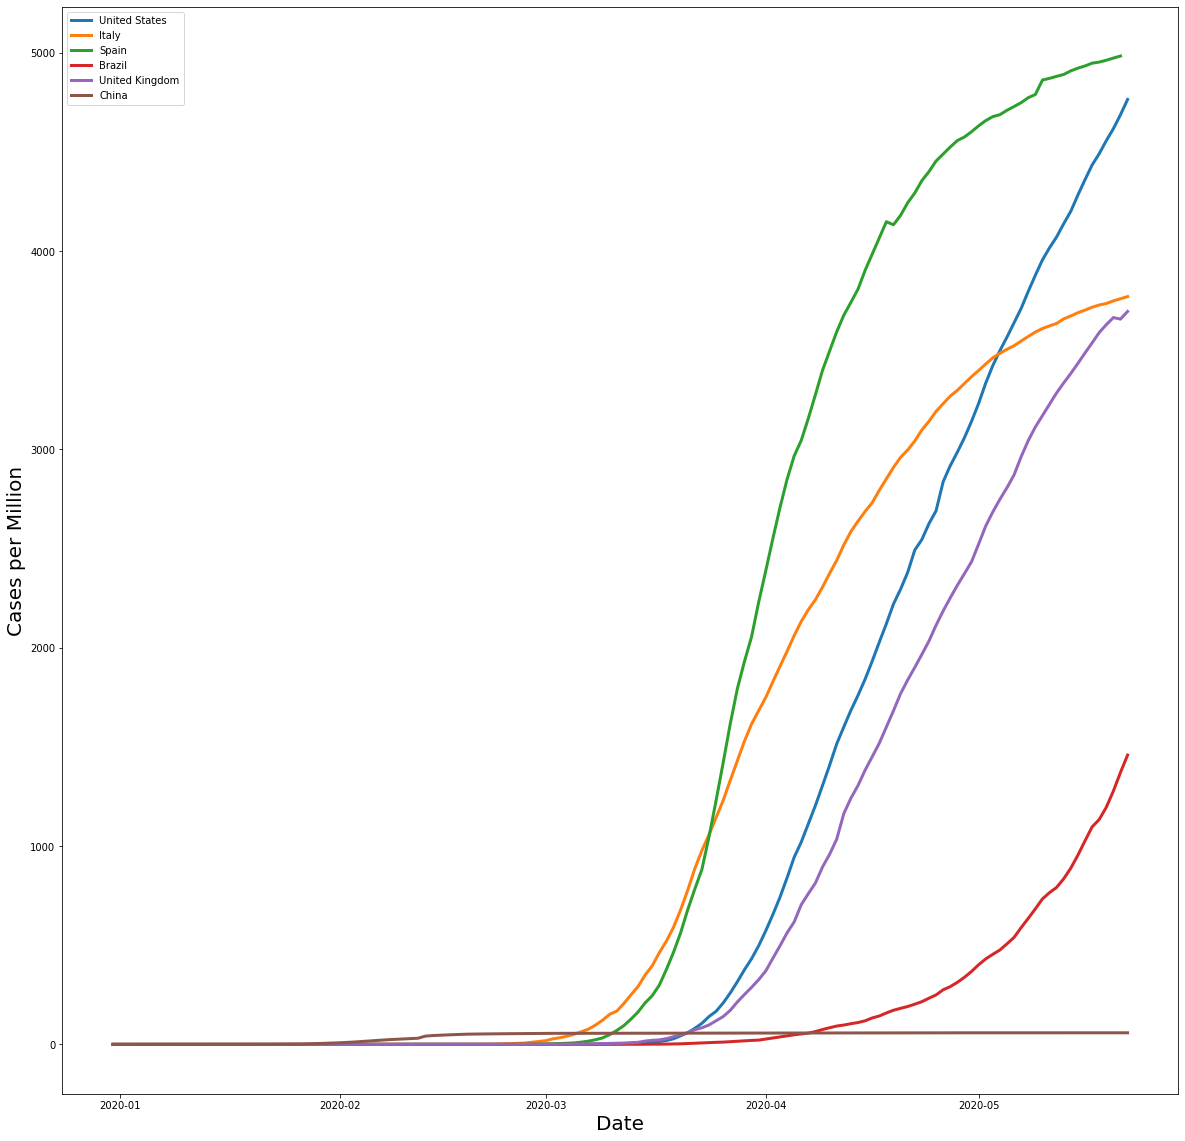

In [30]:
countries_to_plot = ['United States',
                     'Italy',
                     'Spain',
                     'Brazil',
                     'United Kingdom',
                     'China']

fig, ax = plt.subplots(1,figsize=(20,20))

for country in range(len(countries_to_plot)):
    plot_date = df['date'][df.location == countries_to_plot[country]]
    plot_cases = df['total_cases_per_million'][df.location == countries_to_plot[country]]
    plot_deaths = df['total_deaths_per_million'][df.location == countries_to_plot[country]]
    
    ax.plot(plot_date,plot_cases,
             label=countries_to_plot[country],
             linewidth=3)
    ax.set_ylabel('Cases per Million',fontsize=20)
    ax.set_xlabel('Date',fontsize=20)
    
    

ax.legend()
plt.show()

In [31]:
'''countries_to_plot = ['United States',
                     'Italy',
                     'Spain',
                     'Brazil',
                     'United Kingdom',
                     'China']

fig, ax = plt.subplots(1,figsize=(20,20))

for country in range(len(countries_to_plot)):    
    plot_date = df['date'][df.location == countries_to_plot[country]]
    plot_deaths = df['total_deaths_per_million'][df.location == countries_to_plot[country]]
    
    ax2=ax.twinx()
    ax2.plot(plot_date,plot_deaths,
             label=countries_to_plot[country],
             linewidth=3)
    #ax2.set_ylabel('Deaths per Million',fontsize=20)
    

plt.legend()
plt.show()'''

"countries_to_plot = ['United States',\n                     'Italy',\n                     'Spain',\n                     'Brazil',\n                     'United Kingdom',\n                     'China']\n\nfig, ax = plt.subplots(1,figsize=(20,20))\n\nfor country in range(len(countries_to_plot)):    \n    plot_date = df['date'][df.location == countries_to_plot[country]]\n    plot_deaths = df['total_deaths_per_million'][df.location == countries_to_plot[country]]\n    \n    ax2=ax.twinx()\n    ax2.plot(plot_date,plot_deaths,\n             label=countries_to_plot[country],\n             linewidth=3)\n    #ax2.set_ylabel('Deaths per Million',fontsize=20)\n    \n\nplt.legend()\nplt.show()"

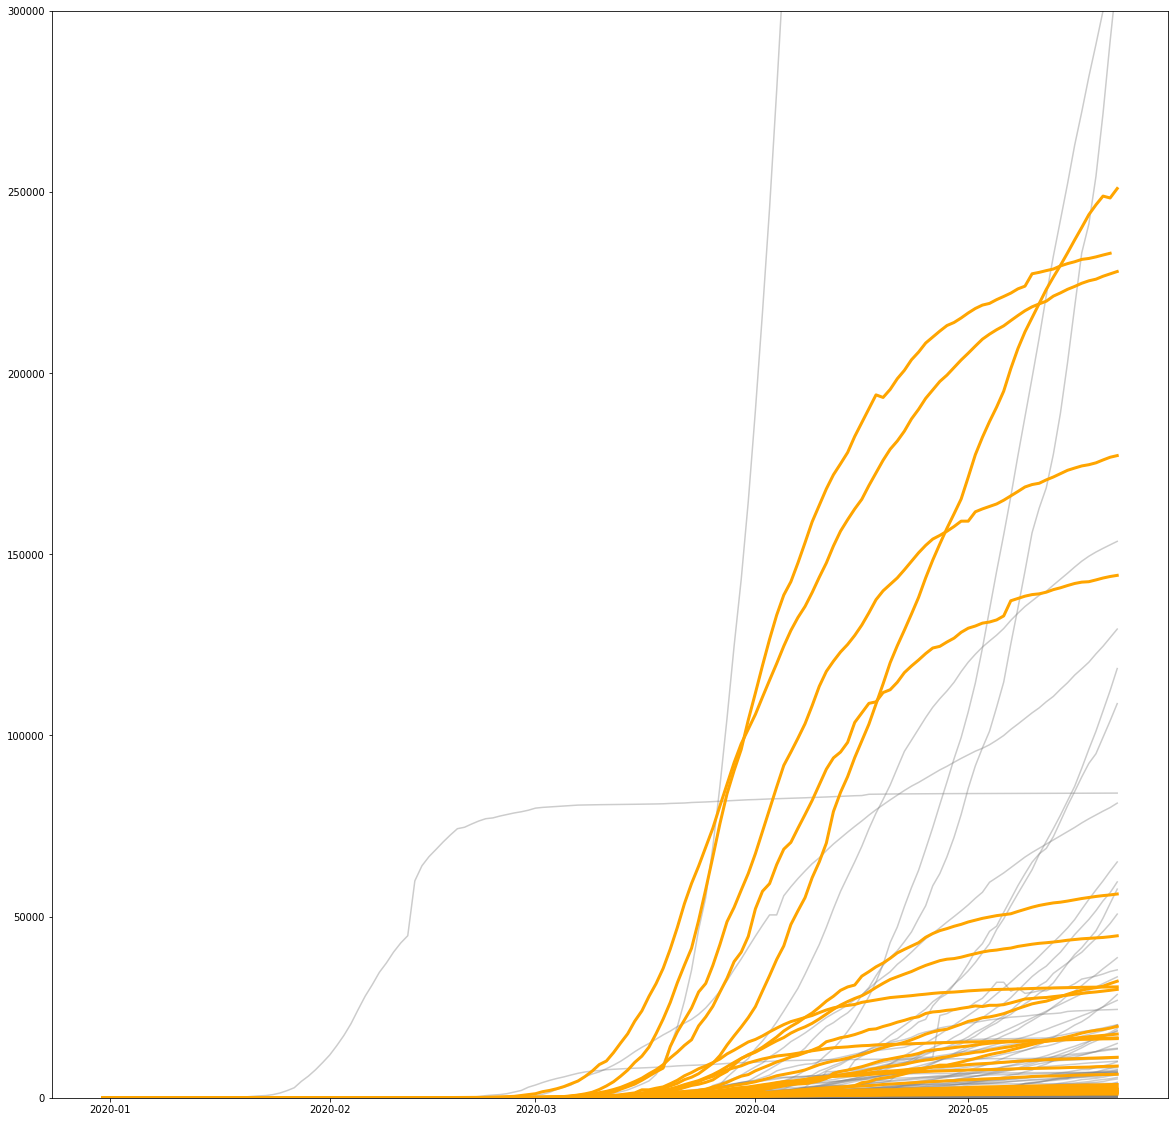

In [32]:
group_country = df.groupby(['date','location']).sum().reset_index()

#select 20 countries with the highest rate of people over 70
countries_top70 = df.groupby(['location','aged_70_older']).sum().reset_index()[['location','aged_70_older']].sort_values('aged_70_older',ascending=False)[0:25].location

fig, ax = plt.subplots(1, figsize=(20,20))

for country in group_country.location.unique():
    ax.plot(group_country['date'][group_country.location == country],
            group_country['total_cases'][group_country.location == country],
            c='grey',
            alpha=0.4)

    
for country in group_country.location.unique():
    if country in list(countries_top70):
        ax.plot(group_country['date'][group_country.location == country],
                group_country['total_cases'][group_country.location == country],
                c='orange',
                alpha=1,
                linewidth=3)
        
ax.set_ylim(0,300000)
plt.show()

In [33]:
df.groupby('location').mean()['hospital_beds_per_100k']

location
Afghanistan       0.50
Albania           2.89
Algeria           1.90
Angola             NaN
Argentina         5.00
                  ... 
Vietnam           2.60
Western Sahara     NaN
Yemen             0.70
Zambia            2.00
Zimbabwe          1.70
Name: hospital_beds_per_100k, Length: 168, dtype: float32

In [34]:
df.columns

Index(['geometry', 'location', 'date', 'total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_units',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cvd_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_100k',
       'continent', 'alpha2', 'latitude', 'longitude'],
      dtype='object')

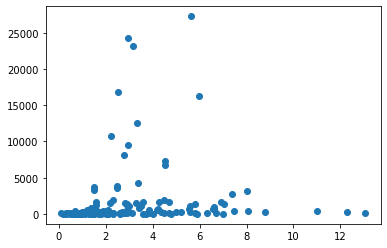

In [35]:
plt.scatter(df.groupby('location').mean()['hospital_beds_per_100k'], df.groupby('location').sum()['total_deaths_per_million'])
plt.show()

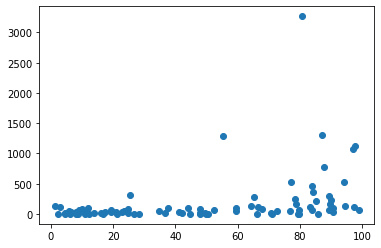

In [36]:
plt.scatter(df.groupby('location').mean()['handwashing_facilities'], df.groupby('location').sum()['total_deaths_per_million'])
plt.show()

In [37]:
df.columns

Index(['geometry', 'location', 'date', 'total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_units',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cvd_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_100k',
       'continent', 'alpha2', 'latitude', 'longitude'],
      dtype='object')

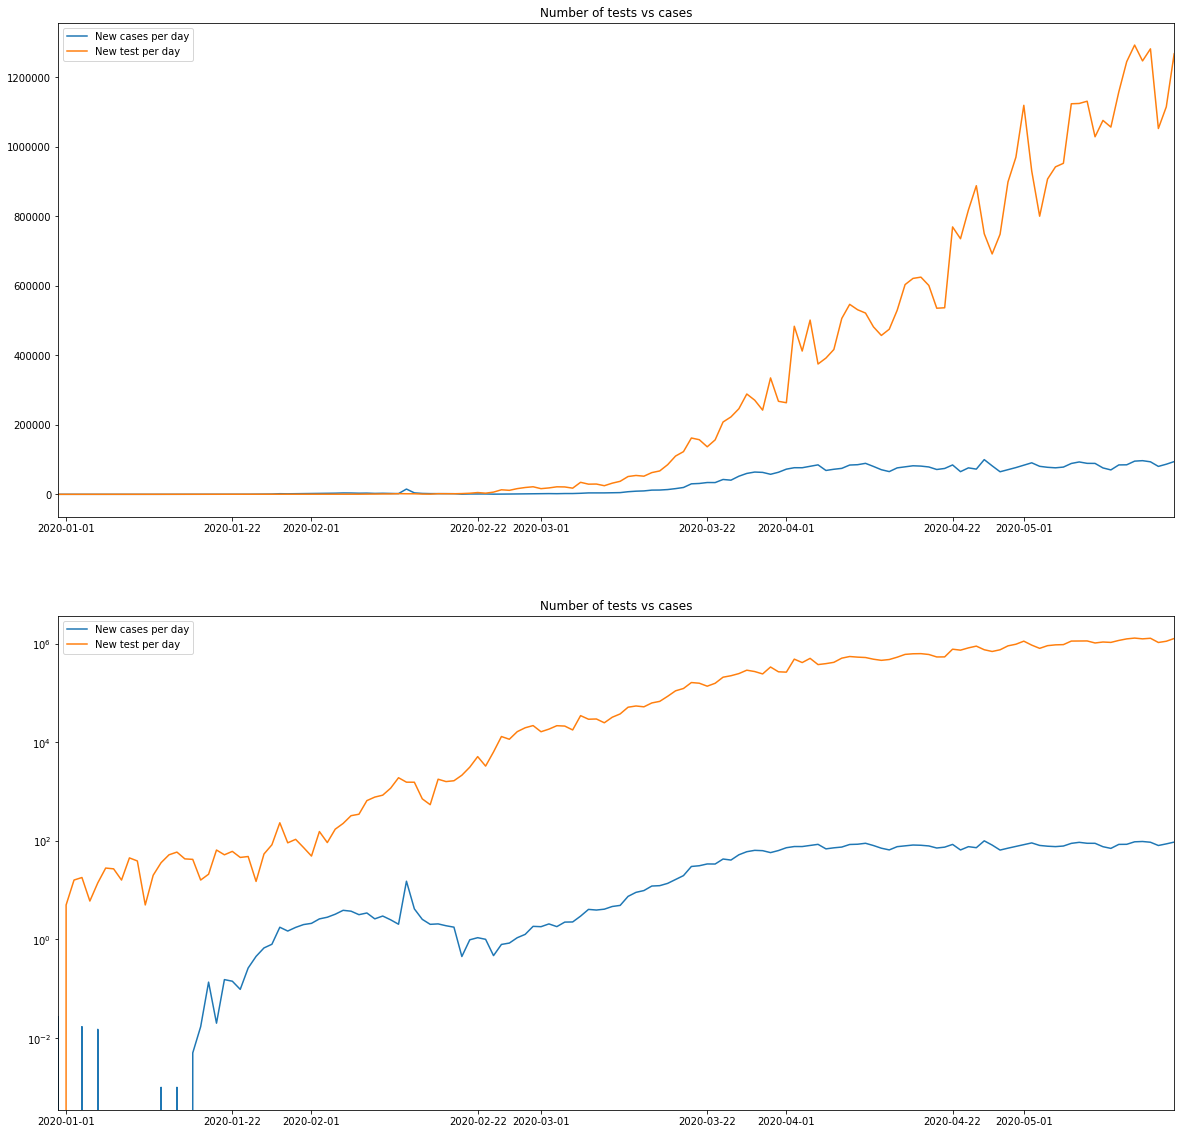

In [38]:
fig,ax = plt.subplots(2,figsize=(20,20))

groupby_today = df.groupby('date').sum()

#plot on ax one
ax[0].plot(groupby_today.index, groupby_today['new_cases'], label='New cases per day')
ax[0].plot(groupby_today.index, groupby_today['new_tests'], label='New test per day')
#plot on ax two
ax[1].plot(groupby_today.index, groupby_today['new_cases']*1/1000, label='New cases per day')
ax[1].plot(groupby_today.index, groupby_today['new_tests'], label='New test per day')


ax[0].set_xlim(groupby_today.index[0],groupby_today.index[-3])
ax[0].set_title("Number of tests vs cases")

ax[1].set_xlim(groupby_today.index[0],groupby_today.index[-3])
ax[1].set_title("Number of tests vs cases")

ax[0].legend()
ax[1].legend()

ax[1].set_yscale("log")
plt.show()

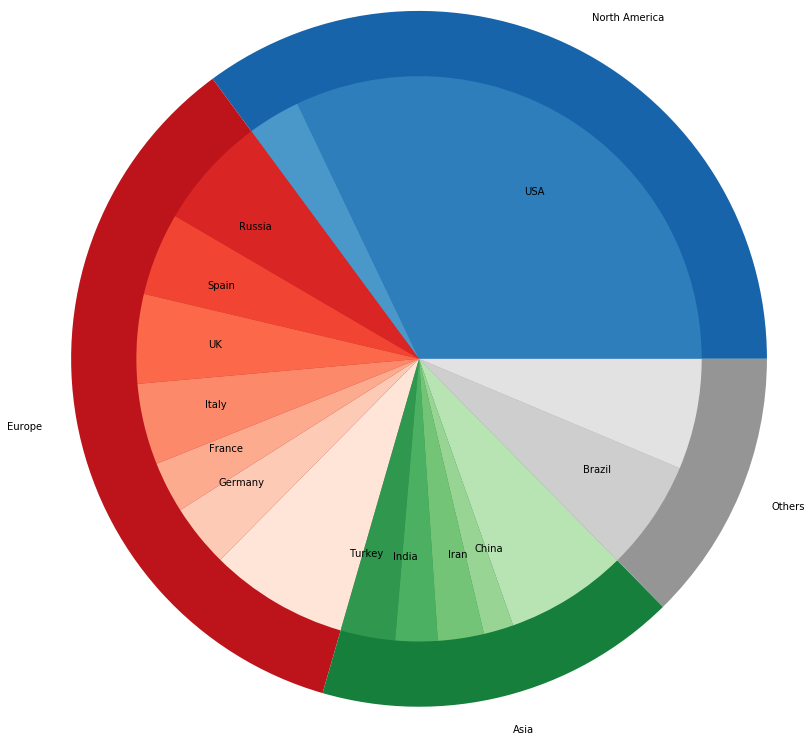

In [39]:
#https://python-graph-gallery.com/163-donut-plot-with-subgroups/
#create nested pie chart

group_continent = df.groupby(['date','continent']).sum().reset_index()
#main continent cases - using iloc here because ocasionally the most recent value is skew
namerica_total = group_continent.total_cases[group_continent.continent == 'North America'].iloc[-2]
europe_total = group_continent.total_cases[group_continent.continent == 'Europe'].iloc[-2]
asia_total = group_continent.total_cases[group_continent.continent == 'Asia'].iloc[-2]
#other cases
samerica_total = group_continent.total_cases[group_continent.continent == 'South America'].iloc[-2]
africa_total = group_continent.total_cases[group_continent.continent == 'Africa'].iloc[-2]
australia_total = group_continent.total_cases[group_continent.continent == 'Australia'].iloc[-2]

#plot certain countries
us_total = max(df[(df.location == "United States")].total_cases)

russia_total = max(df[(df.location == "Russia")].total_cases)
spain_total = max(df[(df.location == "Spain")].total_cases)
uk_total = max(df[(df.location == "United Kingdom")].total_cases)
italy_total = max(df[(df.location == "Italy")].total_cases)
france_total = max(df[(df.location == "France")].total_cases)
germany_total = max(df[(df.location == "Germany")].total_cases)

turkey_total = max(df[(df.location == "Turkey")].total_cases)
india_total = max(df[(df.location == "India")].total_cases)
iran_total = max(df[(df.location == "Iran")].total_cases)
china_total = max(df[(df.location == "China")].total_cases)

brazil_total = max(df[(df.location == "Brazil")].total_cases)


#set for pie chart
group_names = ['North America','Europe','Asia','Others']
group_size = [namerica_total, europe_total, asia_total, samerica_total+africa_total+australia_total]
subgroup_names = ["USA", "",
                  "Russia", "Spain", "UK", "Italy", "France", "Germany", "",
                  "Turkey", "India", "Iran", "China", "",
                  "Brazil", ""]
subgroup_size = [us_total, namerica_total-us_total, 
                  russia_total, spain_total, uk_total, italy_total, france_total, germany_total, europe_total-spain_total-uk_total-russia_total-italy_total-france_total-germany_total, 
                  turkey_total, india_total, iran_total, china_total, asia_total-india_total-turkey_total-iran_total-china_total, 
                  brazil_total, samerica_total+africa_total+australia_total - brazil_total]

# Create colors
a, b, c, d = [plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Greys]
 
# First Ring (outside)
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.6, labels=group_names, colors=[a(0.8), b(0.8), c(0.8), d(0.5)] )
#plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size,
                   radius=1.6-0.3,
                   labels=subgroup_names,
                   labeldistance=0.7,
                   colors=[a(0.7), a(0.6), b(0.7), b(0.6), b(0.5), b(0.4), b(0.3), b(0.2), b(0.1), c(0.7), c(0.6), c(0.5), c(0.4), c(0.3), d(0.3), d(0.2)])
#plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)


In [40]:
#check where the nan values are
df.groupby('location').mean().isna().mean()

total_cases                 0.000000
new_cases                   0.000000
total_deaths                0.000000
new_deaths                  0.000000
total_cases_per_million     0.000000
new_cases_per_million       0.000000
total_deaths_per_million    0.000000
new_deaths_per_million      0.000000
total_tests                 0.517857
new_tests                   0.565476
total_tests_per_thousand    0.517857
new_tests_per_thousand      0.565476
population                  0.000000
population_density          0.029762
median_age                  0.011905
aged_65_older               0.029762
aged_70_older               0.017857
gdp_per_capita              0.047619
extreme_poverty             0.315476
cvd_death_rate              0.017857
diabetes_prevalence         0.023810
female_smokers              0.226190
male_smokers                0.238095
handwashing_facilities      0.488095
hospital_beds_per_100k      0.130952
latitude                    0.000000
longitude                   0.000000
d

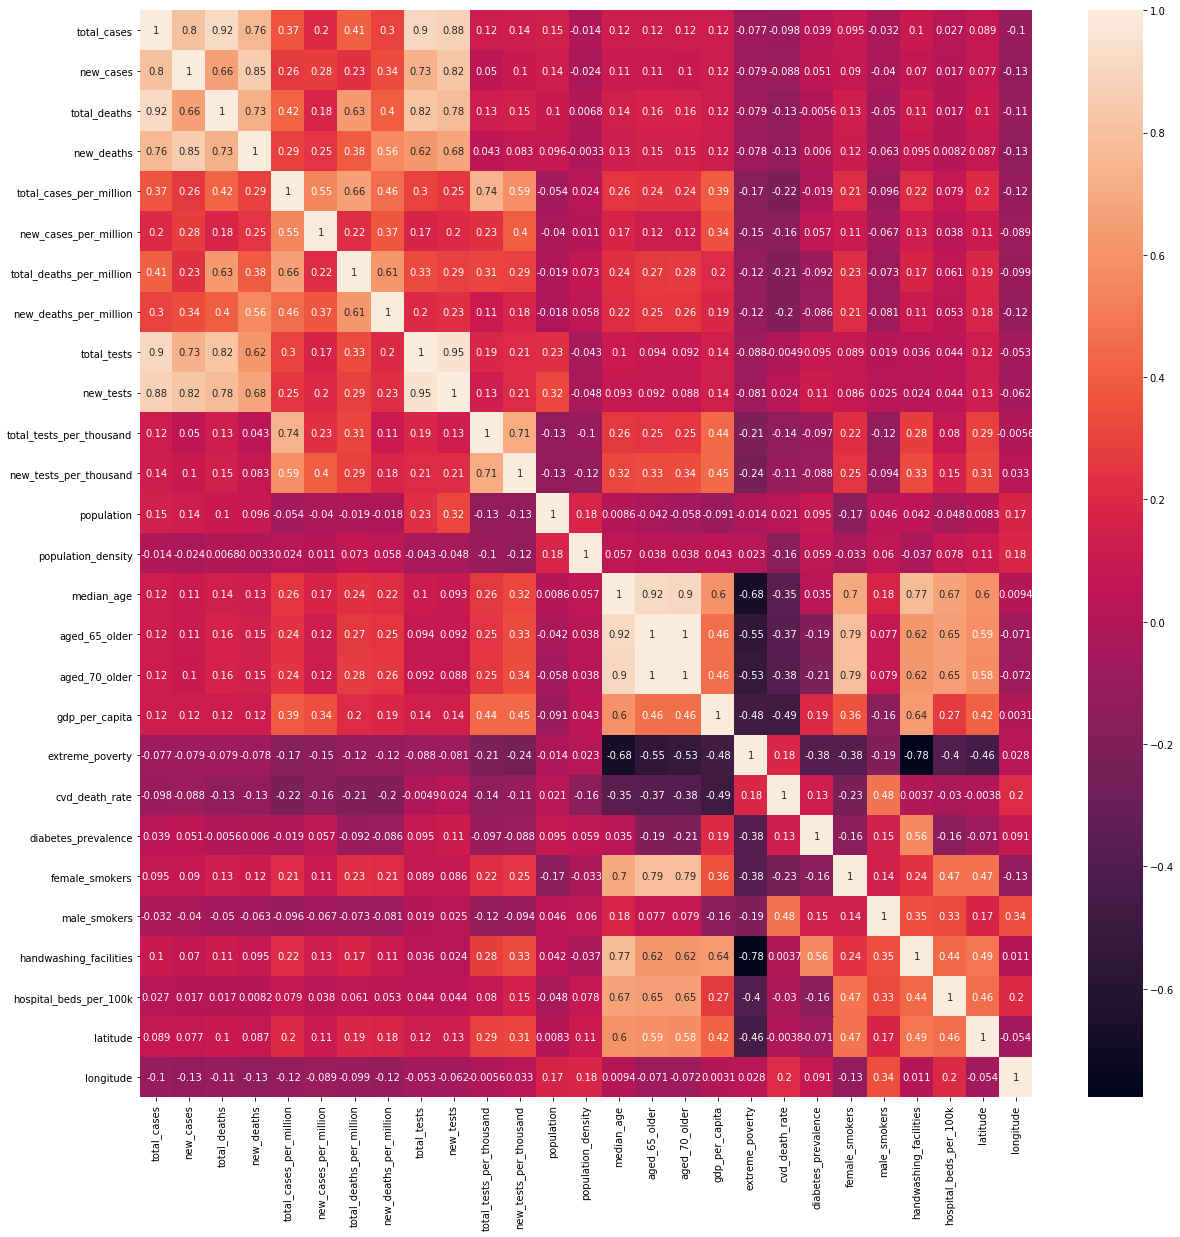

In [41]:
#create heatmap to show correlations

plt.figure(figsize=(20,20))

Var_Corr = df.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)

In [42]:
#make train/test data
#make list and randomly add to list for training data

In [43]:
from sklearn.linear_model import LinearRegression


X = df.groupby('location').mean()[['hospital_beds_per_100k', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cvd_death_rate', 'diabetes_prevalence']]
y = df.groupby('location').sum()['total_cases']

reg = LinearRegression().fit(X,y)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
df.groupby('location').mean()

Wont include handwashing facilities, and male/female smokers.

In [ ]:
df

In [44]:
continent_df

total_cases  gdp_per_capita      continent  population
location                                                              
Afghanistan          8676.0     1803.987061           Asia  38928340.0
Albania               969.0    11803.430664         Europe   2877800.0
Algeria              7728.0    13913.838867         Africa  43851044.0
Angola                 58.0     5819.495117         Africa  32866268.0
Argentina            9918.0    18933.906250  South America  45195776.0
...                     ...             ...            ...         ...
Vietnam               324.0     6171.883789           Asia  97338584.0
Western Sahara          6.0             NaN         Africa    597330.0
Yemen                 193.0     1479.146973           Asia  29825968.0
Zambia                866.0     3689.250977         Africa  18383956.0
Zimbabwe               51.0     1899.775024         Africa  14862927.0

[168 rows x 4 columns]

In [45]:
#groupby location and then resample by week - get new cases
test = df.set_index('date').groupby(['location']).resample("W").sum().reset_index()[['location','date','new_cases']]

In [46]:
for date in test['date'].unique():
    print (date)

2020-01-05T00:00:00.000000000
2020-01-12T00:00:00.000000000
2020-01-19T00:00:00.000000000
2020-01-26T00:00:00.000000000
2020-02-02T00:00:00.000000000
2020-02-09T00:00:00.000000000
2020-02-16T00:00:00.000000000
2020-02-23T00:00:00.000000000
2020-03-01T00:00:00.000000000
2020-03-08T00:00:00.000000000
2020-03-15T00:00:00.000000000
2020-03-22T00:00:00.000000000
2020-03-29T00:00:00.000000000
2020-04-05T00:00:00.000000000
2020-04-12T00:00:00.000000000
2020-04-19T00:00:00.000000000
2020-04-26T00:00:00.000000000
2020-05-03T00:00:00.000000000
2020-05-10T00:00:00.000000000
2020-05-17T00:00:00.000000000
2020-05-24T00:00:00.000000000


In [47]:
#groupby location and then resample by week - get new cases
df.set_index('date').groupby(['location']).resample("M").sum().reset_index()[['date','new_cases']]

date  new_cases
0   2019-12-31        0.0
1   2020-01-31        0.0
2   2020-02-29        1.0
3   2020-03-31      140.0
4   2020-04-30     1808.0
..         ...        ...
677 2020-04-30       62.0
678 2020-05-31      769.0
679 2020-03-31        7.0
680 2020-04-30       27.0
681 2020-05-31       17.0

[682 rows x 2 columns]

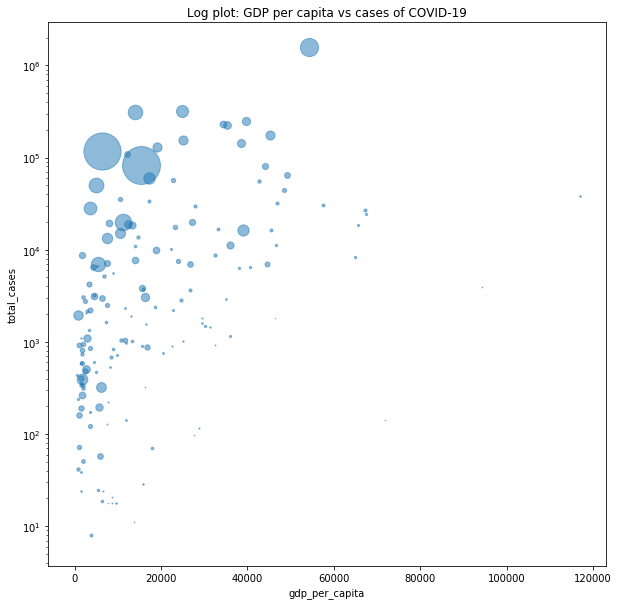

In [48]:
fig, ax = plt.subplots(figsize = (10,10))

#color of dots
color = {'Africa':'red',
         'Asia':'blue',
         'Europe':'green',
         'North America':'black',
         'Australia':'yellow',
         'South America':'purple'}

# plot scatter plot
grouped = continent_df.reset_index().groupby('population')
for key, group in grouped:
    group.plot(ax=ax,
                kind='scatter',
                x='gdp_per_capita',
                y='total_cases',
                #label=key,
                #color=color[key],
                alpha = 0.5,
                s = key/1000000)
plt.yscale("log")

plt.title("Log plot: GDP per capita vs cases of COVID-19")
plt.show()

In [49]:
grouped = continent_df.reset_index().groupby(['continent','location','population'])
for key, group in grouped:
    print (key)

('Africa', 'Algeria', 43851044.0)
('Africa', 'Angola', 32866268.0)
('Africa', 'Benin', 12123198.0)
('Africa', 'Botswana', 2351625.0)
('Africa', 'Burkina Faso', 20903278.0)
('Africa', 'Burundi', 11890781.0)
('Africa', 'Cameroon', 26545864.0)
('Africa', 'Central African Republic', 4829764.0)
('Africa', 'Chad', 16425859.0)
('Africa', 'Congo', 5518092.0)
('Africa', "Côte d'Ivoire", 26378276.0)
('Africa', 'Democratic Republic of the Congo', 89561408.0)
('Africa', 'Djibouti', 988002.0)
('Africa', 'Egypt', 102334400.0)
('Africa', 'Equatorial Guinea', 1402985.0)
('Africa', 'Eritrea', 3546427.0)
('Africa', 'Ethiopia', 114963584.0)
('Africa', 'Gabon', 2225728.0)
('Africa', 'Gambia', 2416664.0)
('Africa', 'Ghana', 31072944.0)
('Africa', 'Guinea', 13132792.0)
('Africa', 'Guinea-Bissau', 1967998.0)
('Africa', 'Kenya', 53771300.0)
('Africa', 'Lesotho', 2142252.0)
('Africa', 'Liberia', 5057677.0)
('Africa', 'Libya', 6871287.0)
('Africa', 'Madagascar', 27691020.0)
('Africa', 'Malawi', 19129956.0)
('Af

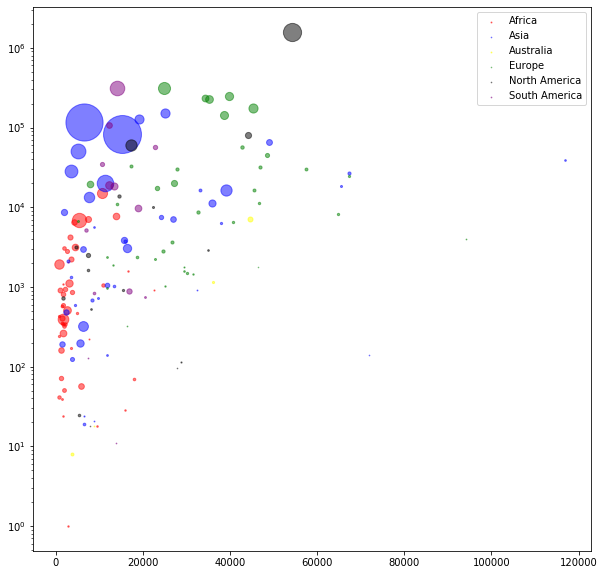

In [164]:
#color of dots
fig, ax = plt.subplots(figsize = (10,10))

color = {'Africa':'red',
         'Asia':'blue',
         'Europe':'green',
         'North America':'black',
         'Australia':'yellow',
         'South America':'purple'}

grouped = continent_df.dropna().reset_index().groupby(['continent','population'])

continent_used = []
for key, group in grouped:
    if key[0] not in continent_used:
        plt.scatter(x=group['gdp_per_capita'],
                    y=group['total_cases'],
                    label=key[0],
                    color=color[key[0]],
                    alpha = 0.5,
                    s = key[1]/1000000)
        continent_used.append(key[0])
    else:
        plt.scatter(x=group['gdp_per_capita'],
                    y=group['total_cases'],
                    #label=key[0],
                    color=color[key[0]],
                    alpha = 0.5,
                    s = key[1]/1000000)
        #plt.plot(group['gdp_per_capita'],group['total_cases'],color=color[key[0]])

plt.yscale("log")

plt.legend()
plt.show()

In [199]:
continent_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, Afghanistan to Zimbabwe
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_cases     168 non-null    float32
 1   gdp_per_capita  160 non-null    float32
 2   continent       168 non-null    object 
 3   population      168 non-null    float64
dtypes: float32(2), float64(1), object(1)
memory usage: 10.2+ KB


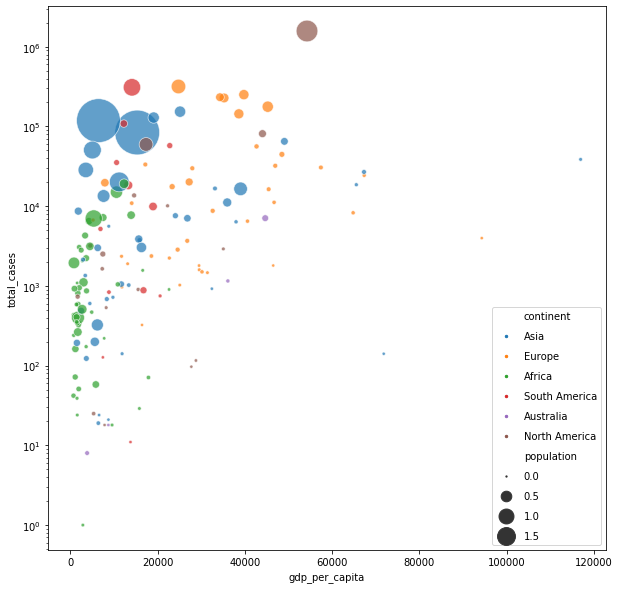

In [281]:
plt.figure(figsize=(10,10))

sns.scatterplot(data=continent_df,
                       x='gdp_per_capita',
                       y='total_cases',
                       size='population',
                       sizes=(10, 2000),
                       hue='continent',
                       alpha=0.7
                           )
plt.legend(loc='lower right',markerscale=0.4,labelspacing=1)
plt.yscale("log")
plt.show()

Now lets animate the plot by time

ValueError: not enough values to unpack (expected 2, got 1)

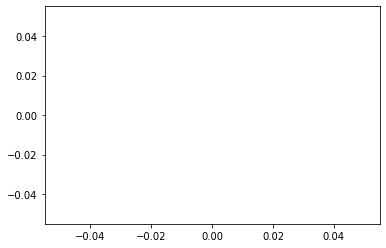

In [273]:
#import matplotlib animate module
from matplotlib.animation import FuncAnimation

#create dataframe


In [306]:
df.set_index(['date']).min()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



RecursionError: maximum recursion depth exceeded while calling a Python object

In [283]:
#Create median age bins
to_sort = df.groupby('location').mean()['median_age']
bins = [0,20,30,40,50]

age_bins = pd.cut(to_sort,bins,labels = ['<20','20-30','30-40','40-50'])

In [284]:
#New age bin column
to_bin = lambda x: age_bins[x]
df['age_bins'] = df.location[df.location.notna()].apply(to_bin).astype(str)
df['age_bins'] = df['age_bins'].astype(str)

df['age_bins'].unique()

array(['nan', '<20', '30-40', '40-50', '20-30'], dtype=object)

In [285]:
df['age_bins'].value_counts()

30-40    4603
20-30    4355
40-50    4298
<20      2544
nan       122
Name: age_bins, dtype: int64

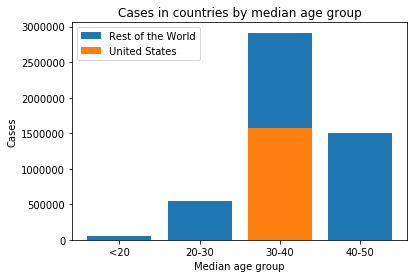

In [286]:
#make df that is first grouped by country and age group
country_age = df.groupby(['location','age_bins'])[['total_cases','total_deaths']].max().reset_index()
#set the order in which the bars should appear
cases_age = country_age.groupby('age_bins').sum().reindex(['<20', '20-30', '30-40','40-50']).reset_index()

#bars for the whole world
plt.bar(cases_age['age_bins'],
        cases_age['total_cases'],
        label='Rest of the World')

#bars for the US
plt.bar(country_age['age_bins'][(country_age['age_bins'] != 'nan') & (country_age['location'] == 'United States')],
        country_age['total_cases'][(country_age['age_bins'] != 'nan') & (country_age['location'] == 'United States')],
        label='United States')

plt.title("Cases in countries by median age group")
plt.xlabel('Median age group')
plt.ylabel('Cases')

plt.legend()
plt.show()

Now create whole new map

In [287]:
#function to return cartesian coordinates
#https://stackoverflow.com/questions/1185408/converting-from-longitude-latitude-to-cartesian-coordinates
def spherical_to_cartesian(lat,long):

    R = 1 #radius of the earth = 6367 km

    x = R * np.cos((lat)/180 *np.pi) * np.cos((long)/180 *np.pi)
    y = R * np.cos((lat)/180 *np.pi) * np.sin((long)/180 *np.pi)
    z = R *np.sin((lat)/180 *np.pi)

    return x,y,z

In [288]:
#create new x, y and z cartesian columns
df['x'] = spherical_to_cartesian(df['latitude'],df['longitude'])[0]
df['y'] = spherical_to_cartesian(df['latitude'],df['longitude'])[1]
df['z'] = spherical_to_cartesian(df['latitude'],df['longitude'])[2]

In [289]:
#groupby location and then resample by week - get new cases
country_cases_week = df.set_index('date').groupby(['location']).resample("M").sum().reset_index()[['date','new_cases']]

In [290]:
#groupby location and then resample by week - get cardinal
country_cardinal_week = df.set_index('date').groupby(['location']).resample("M").mean().reset_index()[['x','y','z']]

In [291]:
location_weighted_df = pd.concat([country_cases_week,country_cardinal_week],axis=1)

In [292]:
#Create weighted mean
def wm(x):
    try:
        return np.average(x, weights=location_weighted_df.loc[x.index, "new_cases"])
    except ZeroDivisionError:
        return 0 
    
weighted_df = location_weighted_df.groupby('date').agg(x_weighted_mean=("x", wm),
                                         y_weighted_mean=("y", wm),
                                         z_weighted_mean=("z", wm))

In [293]:
#function to return spherical coordinates
#https://stackoverflow.com/questions/1185408/converting-from-longitude-latitude-to-cartesian-coordinates
def cartesian_to_spherical(x,y,z):
    
    R = 1 #radius of the earth = 6367 km
    
    latitude = np.arcsin(z / R)
    longitude = np.arctan2(y, x)
    
    #convert from radians to degrees
    latitude = (latitude/np.pi)*180
    longitude = (longitude/np.pi)*180
    
    return latitude, longitude

In [294]:
weighted_df['latitude'] = cartesian_to_spherical(weighted_df['x_weighted_mean'],
                           weighted_df['y_weighted_mean'],
                           weighted_df['z_weighted_mean'])[0]
weighted_df['longitude'] = cartesian_to_spherical(weighted_df['x_weighted_mean'],
                           weighted_df['y_weighted_mean'],
                           weighted_df['z_weighted_mean'])[1]

In [295]:
#make data more versatile by adding new_cases
weighted_df = pd.concat([weighted_df,location_weighted_df.groupby('date').sum()],axis=1)

In [296]:
weighted_df

x_weighted_mean  y_weighted_mean  z_weighted_mean   latitude  \
date                                                                       
2019-12-31        -0.212011         0.791240         0.573577  35.000074   
2020-01-31        -0.211398         0.788545         0.571955  34.886701   
2020-02-29        -0.205838         0.772299         0.575475  35.132875   
2020-03-31         0.420340        -0.078223         0.641314  39.889854   
2020-04-30         0.250047        -0.237398         0.605398  37.257467   
2020-05-31         0.221558        -0.210164         0.457936  27.254005   

             longitude  new_cases          x          y          z  
date                                                                
2019-12-31  104.999927       27.0  19.298927  17.807320  32.329431  
2020-01-31  105.007304     9786.0  19.298927  17.807320  32.329431  
2020-02-29  104.923901    74567.0  22.109316  18.555840  33.897161  
2020-03-31  -10.541857   707975.0  69.778002  21.857911  53.722875  
2020-04-30  -43.513511  2316056.0  75.957123  23.532327  53.231812  
2020-05-31  -43.488153  1912850.0  76.979125  24.682826  53.362074

In [297]:
weighted_df.loc['2020-03-31'].longitude-10

-20.541857493433803

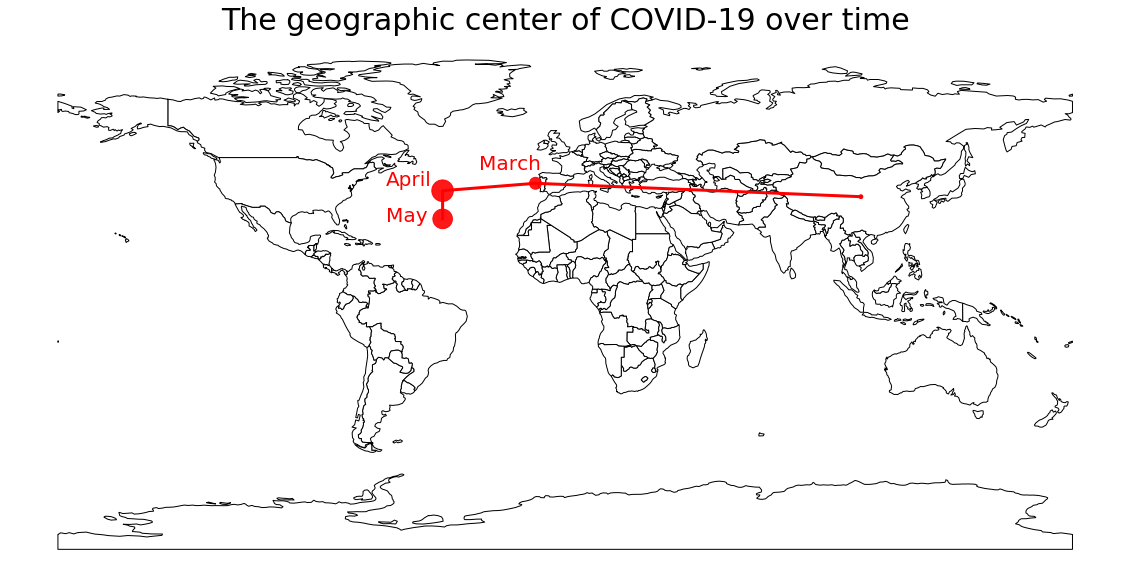

In [298]:
#plot movement of COVID-19 across the world
#https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html


#plot world
ax = world.plot(color='white', edgecolor='black', figsize = (20,20))

#plot data
plt.scatter(weighted_df.longitude,
            weighted_df.latitude,
            color='red',
            s=weighted_df.new_cases/5000,
            alpha =0.9)
plt.plot(weighted_df.longitude,
            weighted_df.latitude,
            color ='red',
            linewidth=3)

#plt.xlim(10,150)
#plt.ylim(-20,60)



plt.annotate("March",
             (weighted_df.loc['2020-03-31'].longitude, weighted_df.loc['2020-03-31'].latitude),
             (weighted_df.loc['2020-03-31'].longitude  - 20, weighted_df.loc['2020-03-31'].latitude + 5),
             fontsize=20,
             color='red')
plt.annotate("April",
             (weighted_df.loc['2020-04-30'].latitude,weighted_df.loc['2020-04-30'].latitude),
             (weighted_df.loc['2020-04-30'].longitude  - 20, weighted_df.loc['2020-04-30'].latitude + 2),
             fontsize=20,
             color='red')
plt.annotate("May",
             (weighted_df.loc['2020-05-31'].longitude,weighted_df.loc['2020-05-31'].latitude),
             (weighted_df.loc['2020-05-31'].longitude - 20,weighted_df.loc['2020-05-31'].latitude - 1),
             fontsize=20,
             color='red')

plt.title("The geographic center of COVID-19 over time", fontsize = 30)

plt.axis('off')
plt.show()

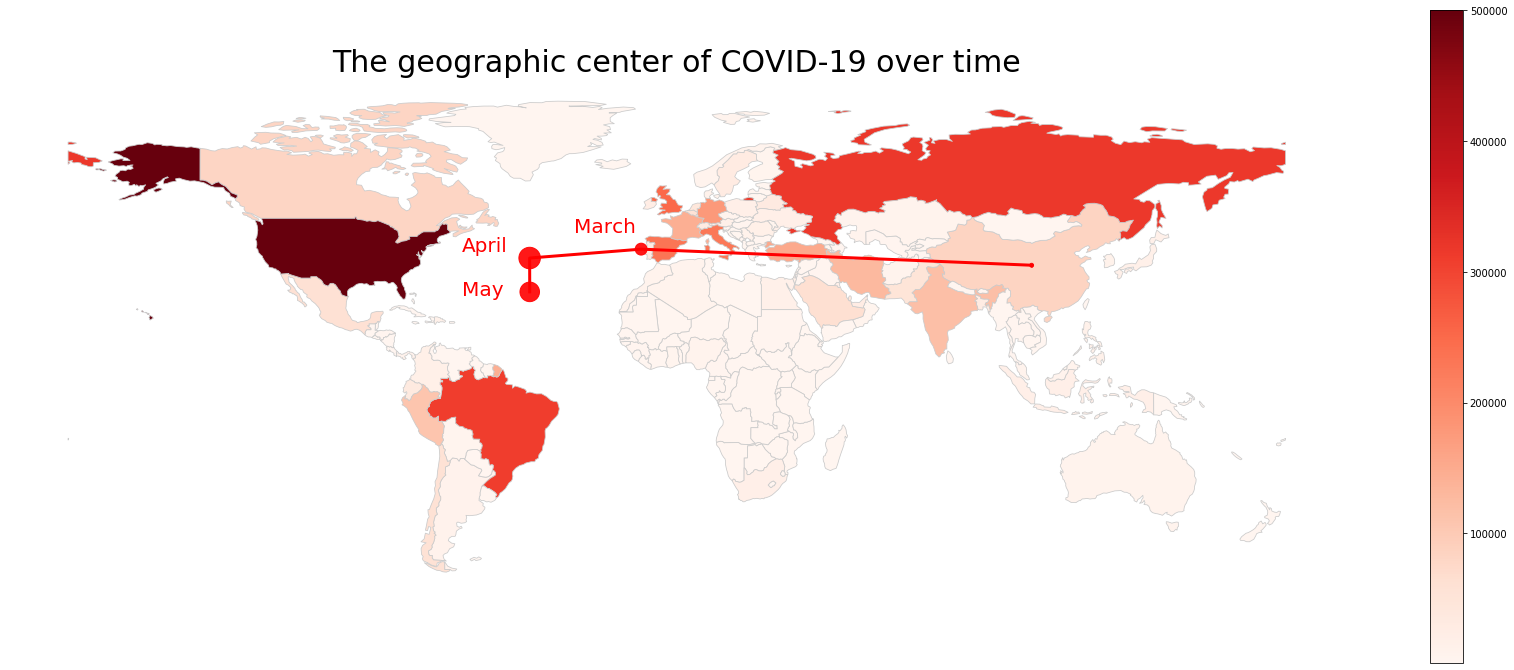

In [299]:
# set the range for the choropleth
vmin, vmax = 1000, 500000
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 12))

total_cases_df.plot(column='total_cases',
                    cmap='Reds',
                    linewidth=0.8,
                    ax=ax,
                    edgecolor='0.8',
                    vmin=vmin,
                    vmax=vmax,figsize=(30,20))
ax.set_title("Total Coronavirus cases")

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)


#plot data
plt.scatter(weighted_df.longitude,
            weighted_df.latitude,
            color='red',
            s=weighted_df.new_cases/5000,
            alpha =0.9)
plt.plot(weighted_df.longitude,
            weighted_df.latitude,
            color ='red',
            linewidth=3)
#annote the points
plt.annotate("March",
             (weighted_df.loc['2020-03-31'].longitude, weighted_df.loc['2020-03-31'].latitude),
             (weighted_df.loc['2020-03-31'].longitude  - 20, weighted_df.loc['2020-03-31'].latitude + 5),
             fontsize=20,
             color='red')
plt.annotate("April",
             (weighted_df.loc['2020-04-30'].latitude,weighted_df.loc['2020-04-30'].latitude),
             (weighted_df.loc['2020-04-30'].longitude  - 20, weighted_df.loc['2020-04-30'].latitude + 2),
             fontsize=20,
             color='red')
plt.annotate("May",
             (weighted_df.loc['2020-05-31'].longitude,weighted_df.loc['2020-05-31'].latitude),
             (weighted_df.loc['2020-05-31'].longitude - 20,weighted_df.loc['2020-05-31'].latitude - 1),
             fontsize=20,
             color='red')

plt.title("The geographic center of COVID-19 over time", fontsize = 30)

plt.axis('off')
plt.show();

In [ ]:
#Global cases
fig = plt.figure()
ax = plt.axes()

#ax.plot(x, np.sin(x));
#data
groupby_global = df.groupby('date').sum()
x = groupby_global.index
y = groupby_global.total_cases

#plot
ax.plot(x,y,c='r')
ax.bar(x,y)
ax.tick_params(axis='x',which='both',labelbottom=False)
ax.set_title('Global cases over time')
ax.set_xlabel("Date")
ax.set_ylabel("Cases")

#save figure
plt.savefig('/Users/sebastiangraff/Desktop/Data_Analysis/COVID19-Exploration/plot_images/global_cases.png')
plt.show();

In [ ]:
#Global cases vs deaths
fig, ax = plt.subplots(figsize = (15,5),nrows=1,ncols=2)

#data
groupby_global = df.groupby('date').sum()
x = groupby_global.index
y1 = groupby_global.total_cases
y2 = groupby_global.total_deaths

#plot
ax[0].plot(x,y1,c='purple',label='Cases')
ax[0].plot(x,y2,c='red',label='Deaths')
ax[0].tick_params(axis='x',which='both',labelbottom=False)
ax[0].set_title('Global cases over time')
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Cases")

ax[1].plot(x,y1,c='purple',label='Cases')
ax[1].plot(x,y2,c='red',label='Deaths')
ax[1].tick_params(axis='x',which='both',labelbottom=False)
ax[1].set_title('Global logarithimic cases over time,')
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Cases")
ax[1].set_yscale('log')

#save figure
ax[0].legend()
ax[1].legend()
plt.savefig('/Users/sebastiangraff/Desktop/Data_Analysis/COVID19-Exploration/plot_images/global_cases_vs_deaths.png')
plt.show();

In [ ]:
groupby_global = df.groupby('date').sum()
groupby_global

In [ ]:
#Global cases vs tests

#data
groupby_global = df.groupby('date').sum()
x = groupby_global.new_tests
y = groupby_global.new_cases

plt.scatter(x,y)
plt.title("COVID-19 Cases vs number of Tests")
plt.xlabel("Tests")
plt.ylabel("Cases")

plt.savefig('/Users/sebastiangraff/Desktop/Data_Analysis/COVID19-Exploration/plot_images/global_tests_vs_cases.png')
plt.show();

In [ ]:
#Stacked plot by continents

#data
groupby_continent = df.groupby('continent').sum()
x=df.date
y=df.total_cases[df.continent ==]
 
# Basic stacked area chart.
plt.stackplot(x,y, labels=df.continent.unique())
plt.legend(loc='upper left')

In [ ]:
from collections import defaultdict

#Data
continent_dict=defaultdict(list)
for index, row in df.iterrows():
    continent_dict[row.continent].append(row.total_cases)

x=df.date
y1=continent_dict['North America']
y2=continent_dict['Asia']
y3=continent_dict['Africa']
y4=continent_dict['Europa']
y5=continent_dict['South America']
y6=continent_dict['Australia']
 
# Plot
plt.stackplot(continent_dict.keys(), y1,y2, labels=continent_dict.keys())
plt.legend(loc='upper left')
plt.show();

#np.array(d.keys(),dtype=float)